# Into the Ether: An Ethereum Cryptocurrency Price Predictor

### Using a linear regressor and a recurrent neural network to predict the value of Ethereum cryptocurrency

HooHacks 2021

Nicholas Lin, Neha Pattanaik, Raghav Khator, Justin Ngo

## Explanation

For the hackathon, we decided to try to predict the price of Ethereum, the second largest Cryptocurrency on the market. Compared to Bitcoin, Ethereum is not a store of value but rather programmable money. The Ethereum network hosts smart contracts which allow for innovative uses of blockchain technology such as Decentralized Finance and Non-Fungible Tokens. Cryptocurrency is leading a revolution in the finance industry as we know it. In addition, our group shared an interest in the intersection of finance and technology. Therefore, we set out to predict the price of Ethereum using Machine Learning.

For our project, we used the publicly available Ethereum dataset from https://www.cryptodatadownload.com/data/gemini/. The dataset contains the market data from the Gemini exchange.

In [ ]:
import sklearn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pd.set_option('max_colwidth', 400)

seed=42
np.random.seed(seed)

In [ ]:
csv_path = "gemini_ETHUSD_day.csv"
usd = pd.read_csv(csv_path)
usd.rename(columns={'Unix Timestamp':'Unix_Timestamp'}, inplace=True)


## Visualizing the Data

The first step we took in creating our predictor was visualizing the data to gain a better understanding of the dataset.

The variables are described below (prices are in USD):

Unix Timestamp - Unix Timestamp of date of trade

Date - Date in EST 

Symbol - Symbol is ETHUSD, meaning the data is for ETHUSD

Open - The price of Ethereum at the opening of the market that day

High - The highest price that Ethereum was traded for that day

Low - The lowest price that Ethereum was traded for that day

Close - The price of Ethereum at the closing time of the market that day

Volume - The amount of Ethereum traded

In [ ]:
usd = usd.sort_values(by=['Unix_Timestamp'], ascending=True)
usd.head(10)

,Unix_Timestamp,Date,Symbol,Open,High,Low,Close,Volume
1783,1.462766e+09,5/9/2016 4:00,ETHUSD,0.00,12.00,0.00,9.36,1376.614767
1782,1.462853e+09,5/10/2016 4:00,ETHUSD,9.36,9.95,9.36,9.74,764.628290
1781,1.462939e+09,5/11/2016 4:00,ETHUSD,9.74,10.47,9.69,10.45,3079.531401
1780,1.463026e+09,5/12/2016 4:00,ETHUSD,10.45,12.00,9.92,10.40,2061.012106
1779,1.463112e+09,5/13/2016 4:00,ETHUSD,10.40,11.59,10.20,10.50,1788.043079
1778,1.463198e+09,5/14/2016 4:00,ETHUSD,10.50,10.58,10.01,10.57,930.580655
1777,1.463285e+09,5/15/2016 4:00,ETHUSD,10.57,10.59,10.06,10.06,988.531975
1776,1.463371e+09,5/16/2016 4:00,ETHUSD,10.06,11.41,10.06,11.33,3725.048075
1775,1.463458e+09,5/17/2016 4:00,ETHUSD,11.33,13.06,11.28,13.04,8137.008235
1774,1.463544e+09,5/18/2016 4:00,ETHUSD,13.04,14.14,12.70,13.87,5531.485493


In [ ]:
usd.describe()

,Unix_Timestamp,Open,High,Low,Close,Volume
count,1.784000e+03,1784.000000,1784.000000,1784.000000,1784.000000,1.784000e+03
mean,1.046411e+12,317.779983,330.736015,303.450810,318.755230,3.375506e+04
std,7.369960e+11,355.446057,371.767386,337.274035,356.904823,6.299783e+04
min,1.462766e+09,0.000000,7.290000,0.000000,7.030000,0.000000e+00
25%,1.501279e+09,123.715000,128.195000,119.325000,124.172500,6.748886e+03
50%,1.539795e+12,214.950000,222.875000,206.465000,214.440000,1.696652e+04
75%,1.578302e+12,383.390000,394.357500,370.122500,383.780000,3.696830e+04
max,1.616820e+12,2016.340000,2040.000000,1899.000000,2016.340000,1.824554e+06


Text(0.5, 1.0, 'Price of Ethereum Cryptocurrency over Time')

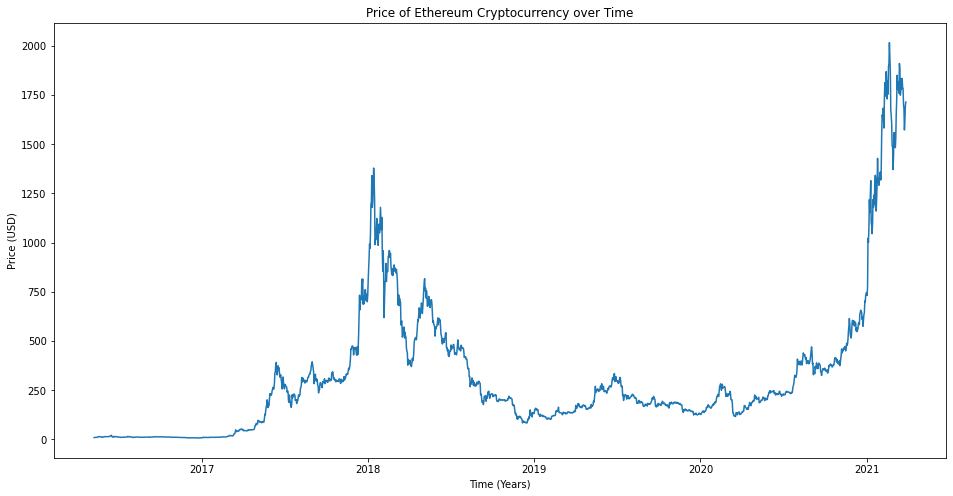

In [ ]:
plt.figure(figsize=(16,8))
usd['Date'] = pd.to_datetime(usd['Date'])
usd.index = usd['Date']
plt.plot(usd['Close'], label='Close Price history')
plt.xlabel('Time (Years)')
plt.ylabel('Price (USD)')
plt.title('Price of Ethereum Cryptocurrency over Time')

Our team played around with using the simple moving average (SMA) in our predictor. We used it to visualize the data at first but decided not to use it in our final predictor.

The SMA_x takes the prices from the last x days and averages them out. Cryptocurrency prices can be volatile so the SMA smooths it out and can give us a simpler metric to compare prices to.

The greater the x, the smoother the graph will be and the less volatile it will appear as we are averaging more days. It allows for less spikes in the prices and better general trends.

For example, one trading technique used is comparing the SMA200 to the current price of bitcoin. If the opening price falls below the 200 day simple moving average, it means that the market has most likely entered the bear market and people are afraid. As a result, people are selling the coins and the price starts to fall as supply outweighs demand.

In [ ]:
def sma(data, days):
  name = "SMA_"+str(days)
  cInd = data.columns.get_loc("Close")
  for i in range(0,data.shape[0]-days+1):
    total = 0
    for j in range(days):
      total+=data.iloc[i+j,cInd]
    data.loc[data.index[i+days-1], name] = np.round(((total)/days),2)
    
# sma(usd, 7)

In [ ]:
# We dropped the unix timestamp column which was just a number represented the time and the symbol was all ETHUSD for the pairing
data = usd.copy()
data = data.drop(columns=['Unix_Timestamp', 'Symbol'])
data.columns
#We installed fastai and used the add_datepart to add date features such as dayofweek and dayofyear
from fastai.tabular import  add_datepart
add_datepart(data, 'Date')
data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp


/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


## Linear Regression Short-Term Predictor

We first used a linear regressor to try to predict the price. The regressor was not powerful enough of a model to provide good results.

In [ ]:
# To predict prices without being influenced by opening price and high and low prices of the day as well as volume. All we will be predicting on is the date.
newData = data.drop(["Open", "High", "Low", "Volume"], axis=1)
newData

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,,
2016-05-09 04:00:00,9.36,2016,5,19,9,0,130,False,False,False,False,False,False
2016-05-10 04:00:00,9.74,2016,5,19,10,1,131,False,False,False,False,False,False
2016-05-11 04:00:00,10.45,2016,5,19,11,2,132,False,False,False,False,False,False
2016-05-12 04:00:00,10.40,2016,5,19,12,3,133,False,False,False,False,False,False
2016-05-13 04:00:00,10.50,2016,5,19,13,4,134,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-23 04:00:00,1679.83,2021,3,12,23,1,82,False,False,False,False,False,False
2021-03-24 04:00:00,1572.81,2021,3,12,24,2,83,False,False,False,False,False,False
2021-03-25 04:00:00,1620.62,2021,3,12,25,3,84,False,False,False,False,False,False


In [ ]:
# We split the data into training and validation sets.
train = newData[:1500]
valid = newData[1500:]

In [ ]:
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression, we do not expect to be that great as it is a fairly limited regressor
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

704.1308612622254

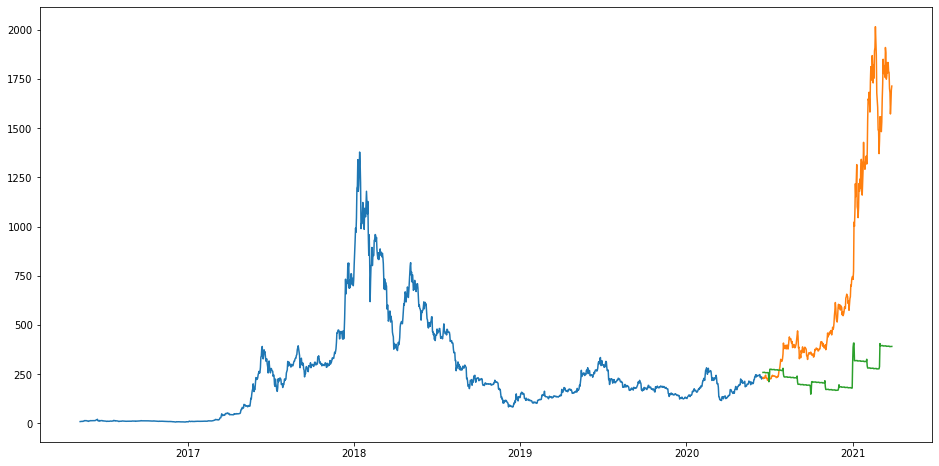

In [ ]:
# We graphed the training data in blue, the validation data in orange, and our 
# predictions in green. As you can see, it was not great at predicting the price
# of Ethereum in the long-term.
predictions = pd.DataFrame()
predictions["Close"] = valid["Close"]
predictions['Predictions'] = 0
predictions['Predictions'] = preds
plt.figure(figsize=(16,8))


plt.plot(train['Close'])
plt.plot(predictions[['Close', 'Predictions']])

## Recurrent Neural Network Predictor

For this part, we search up common ways to predict the prices of stocks and we found that a class of Recurrent Neural Network called Long Short-Term Memory which specializes in prediction problems relating to chronological data. We followed a tutorial to implement the neural network and applied it to the ethereum price. As you can see, the predictor worked fairly well but did not predict the all time highs ethereum reached this past year.

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [ ]:
cols = 13
dataset = newData.values
# First, scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
# Split the data into train and ytrain in overlapping chunks
x_train, y_train = np.array(x_train), np.array(y_train)
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,:])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],cols))

In [ ]:
# We built the model as specified below.
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],cols)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [ ]:
#We trained the model on the training data
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

1440/1440 - 36s - loss: 0.0358


In [ ]:
# This is building the validation set.
inputs = newData[len(newData) - len(valid) - 60:].values
inputs = inputs.reshape(-1,cols)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,:])
X_test = np.array(X_test)

#use the model to predict the prices
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],cols))
closing_price = model.predict(X_test)
#closing_price = scaler.inverse_transform(closing_price)
#Inverse transforming the scaled price back to the original scale.
closeMean = 318.755230
closeSTD = 356.904823
preds = closing_price*closeSTD+closeMean

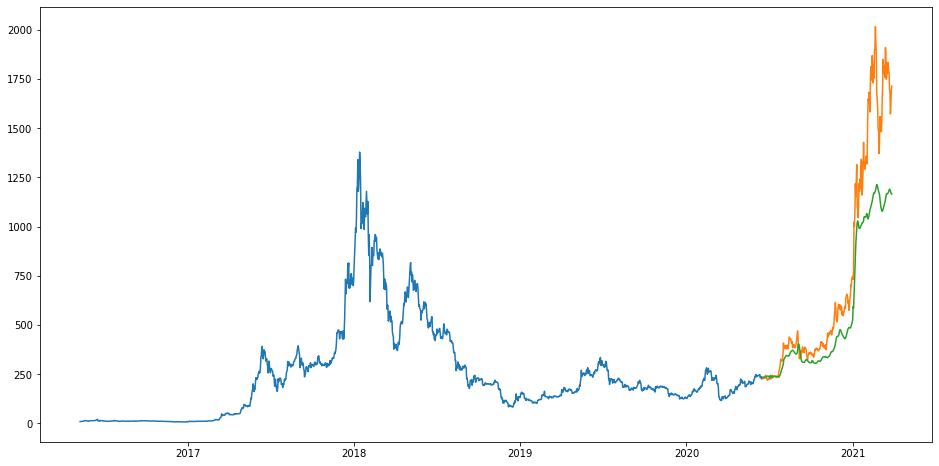

In [ ]:
# We graphed the training data in blue, the validation data in orange, and our 
# predictions in green. As you can see, it was much better predicting the price.
predictions = pd.DataFrame()
predictions["Close"] = valid["Close"]
predictions['Predictions'] = 0
predictions['Predictions'] = preds
plt.figure(figsize=(16,8))


plt.plot(train['Close'])
plt.plot(predictions[['Close', 'Predictions']])

## Conclusion

In future iterations of the project, we could improve our predictor by using more features to train our neural network. We hope to continue advancing the model to begin forecasting the future prices and implementing the Gemini Exchange's API so our model can begin trading with a small amount of money such as a $100. None of the team had used a recurrent neural network before so we had to search up a tutorial on how to do it. We were very suprised at the accuracy of the neural network and were astonished that it was able to predict a general trend not many people saw coming (the past year's cryptocurrency boom). We learned that it is important to scale our features for the recurrent neural network and that a recurrent neural network is a very useful tool for predicting values with chronological data.